## Importing Modules

필요한 모듈을 Import 합니다.


In [1]:
# Modules About Hydra
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import DictConfig

# Modules About Torch
import torch
import torch.nn.functional as F
import torchmetrics
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Modules About Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

# Modules About HuggingFace Transformers
from transformers import ViTImageProcessor, ViTForImageClassification, AdamW


/opt/homebrew/Caskroom/miniconda/base/envs/jobVS_infra_test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configure Dataset

Custom Dataset을 구성합니다.
Data_Module에 있는 CustomDataset을 불러옵니다.


In [2]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 64, data_dir: str = "./"):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize((0.1307,), (0.3081,)),
            # ViT expects 224x224 images
            transforms.Resize((224, 224), antialias=True),
            transforms.Lambda(self.repeat_channels)  # ViT expects 3 channels
        ])

    def repeat_channels(self, x):
        return x.repeat(3, 1, 1)

    def setup(self, stage=None):
        self.mnist_train = datasets.MNIST(
            self.data_dir, train=True, download=True, transform=self.transform
        )
        self.mnist_val = datasets.MNIST(
            self.data_dir, train=False, download=True, transform=self.transform
        )

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

In [3]:
class MyModel(pl.LightningModule):
    def __init__(self, config):
        super(MyModel, self).__init__()
        self.config = config
        self.save_hyperparameters()
        self.model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224")
        self.feature_extractor = ViTImageProcessor.from_pretrained(
            "google/vit-base-patch16-224")

    def forward(self, pixel_values, labels=None):
        output = self.model(pixel_values=pixel_values, labels=labels)
        return output.loss, output.logits

    def training_step(self, batch, batch_idx):
        images, labels = batch
        pixel_values = self.feature_extractor(
            images=images, return_tensors="pt").pixel_values
        loss, logits = self(images, labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        pixel_values = self.feature_extractor(
            images=images, return_tensors="pt").pixel_values
        loss, logits = self(images, labels)
        # loss.requires_grad_(True)
        self.log('val_loss', loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=2e-5)

In [4]:
# 데이터 로드 및 훈련
data_module = MNISTDataModule()
config = {}
model = MyModel(config=config)
trainer = pl.Trainer(max_epochs=1)
trainer.fit(model, data_module)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | ViTForImageClassification | 86.6 M
----------------------------------------------------
86.6 M    Trainable params
0         Non-trainable params
86.6 M    Total params
346.271   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/jobVS_infra_test/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/opt/homebrew/Caskroom/miniconda/base/envs/jobVS_infra_test/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 938/938 [32:26<00:00,  2.08s/it, v_num=23, train_loss=0.00174, val_loss=0.0464]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 938/938 [32:29<00:00,  2.08s/it, v_num=23, train_loss=0.00174, val_loss=0.0464]


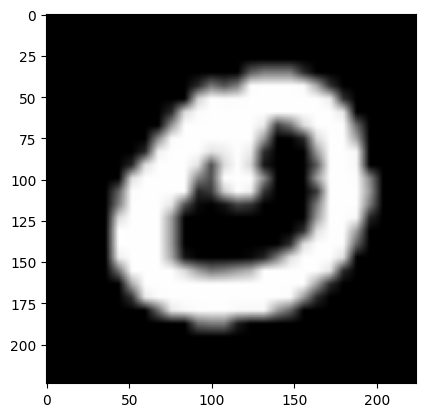

True label: 0, Predicted label: 0


In [36]:
import torch
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 전처리 함수
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # ViT expects 224x224 images
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # ViT expects 3 channels
])

# MNIST 테스트 데이터셋 로드
test_dataset = datasets.MNIST(root='./', train=False, download=True, transform=transform)

# 랜덤 이미지 선택
random_idx = torch.randint(len(test_dataset), size=(1,)).item()
image, true_label = test_dataset[random_idx]

# 이미지 확인 (optional)
plt.imshow(image[0].squeeze(), cmap='gray')
plt.show()

# 모델에 입력하기 위해 배치 차원 추가
image = image.unsqueeze(0)  # (1, 3, 224, 224)

# 모델 생성 및 학습된 가중치 로드
model.eval()  # Evaluation 모드

# 이미지를 모델에 전달하고 출력 받기
with torch.no_grad():
    loss, logits = model(image)

# 가장 높은 확률을 가진 클래스 예측
_, predicted_class = torch.max(logits, dim=1)

print(f'True label: {true_label}, Predicted label: {predicted_class.item()}')


In [38]:
trainer.save_checkpoint("example.ckpt")